In [1]:
import pandas as pd
import scipy.sparse as sparse
import numpy as np
import random
import implicit
import joblib
from sklearn.preprocessing import MinMaxScaler

In [32]:
products_df = pd.read_csv("../IP2022_Spring_8451/data/products.csv",index_col=0)
#Importing the final merged cvs file into transactions dataframe
transactions = pd.read_csv("FinalMergedData.csv")

In [33]:
transactions

,campaign_id,household_id,campaign_type,start_date,end_date,store_id,basket_id,product_id,quantity,sales_value,...,age,income,home_ownership,marital_status,household_size,household_comp,kids_count,transaction_date,transaction_time,coupon_upc
0,1,105,Type B,2017-03-03,2017-04-09,321,3.220465e+10,1095068.0,1,1.67,...,25-34,Under 15K,Homeowner,Unmarried,3,1 Adult Kids,2,2017-03-13,09:29:51,NaN
1,1,105,Type B,2017-03-03,2017-04-09,321,3.220465e+10,852065.0,1,1.69,...,25-34,Under 15K,Homeowner,Unmarried,3,1 Adult Kids,2,2017-03-13,09:29:51,NaN
2,1,105,Type B,2017-03-03,2017-04-09,321,3.220465e+10,1135868.0,1,1.29,...,25-34,Under 15K,Homeowner,Unmarried,3,1 Adult Kids,2,2017-03-13,09:29:51,NaN
3,1,105,Type B,2017-03-03,2017-04-09,321,3.247878e+10,870927.0,1,0.88,...,25-34,Under 15K,Homeowner,Unmarried,3,1 Adult Kids,2,2017-03-27,09:11:15,NaN
4,1,105,Type B,2017-03-03,2017-04-09,321,3.247878e+10,1057113.0,2,4.12,...,25-34,Under 15K,Homeowner,Unmarried,3,1 Adult Kids,2,2017-03-27,09:11:15,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869959,9,997,Type B,2017-05-31,2017-07-02,3182,3.368217e+10,196521.0,2,3.20,...,45-54,75-99K,Homeowner,Unmarried,1,1 Adult No Kids,0,2017-06-12,20:41:43,NaN
869960,9,997,Type B,2017-05-31,2017-07-02,3182,3.368217e+10,372396.0,1,3.79,...,45-54,75-99K,Homeowner,Unmarried,1,1 Adult No Kids,0,2017-06-12,20:41:43,NaN
869961,9,997,Type B,2017-05-31,2017-07-02,3182,3.368217e+10,10212300.0,1,0.99,...,45-54,75-99K,Homeowner,Unmarried,1,1 Adult No Kids,0,2017-06-12,20:41:43,NaN
869962,9,997,Type B,2017-05-31,2017-07-02,3182,3.368217e+10,10462537.0,1,1.89,...,45-54,75-99K,Homeowner,Unmarried,1,1 Adult No Kids,0,2017-06-12,20:41:43,NaN


In [3]:
#Performs data-preprocessing on the input dataframe
#One mandatory parameter: df
#options parameters: cap_value, bins, weights, byBasket
def generateRequiredDataframe(df,cap_value = 30, bins = [0,1,5,30],weights = [1,2,3], byBasket=True):
    if(byBasket):
        df = df.loc[:,["household_id","basket_id","product_id","quantity"]]
        df_preprocessed = df.groupby(["household_id","product_id"]).agg(times_purchased = ("basket_id","count")).reset_index()
        df_preprocessed.loc[df_preprocessed.times_purchased >= cap_value,"times_purchased"] = cap_value
        df_preprocessed["weight"]=pd.cut(df_preprocessed.times_purchased,bins=bins,labels=weights)
    else:
        df = df.loc[:,["household_id","product_id","quantity"]]
        df.loc[df.quantity==0,"quantity"] = 1
        df_preprocessed = df.groupby(["household_id","product_id"]).agg(total_purchase = ("quantity","sum")).reset_index()
        df_preprocessed.loc[df_preprocessed.total_purchase >= cap_value,"total_purchase"] = cap_value
        df_preprocessed["weight"]=pd.cut(df_preprocessed.total_purchase,bins=bins,labels=weights)
    
    #Converting household_id and product_id into categorical variable and equivalent dummy codes
    df_preprocessed['household_id_cat'] = df_preprocessed['household_id'].astype("category")
    df_preprocessed['product_id_cat'] = df_preprocessed['product_id'].astype("category")
    df_preprocessed['household_id_cat'] = df_preprocessed['household_id_cat'].cat.codes
    df_preprocessed['product_id_cat'] = df_preprocessed['product_id_cat'].cat.codes    
    return df_preprocessed

#result = generateRequiredDataframe(transactions)
result = generateRequiredDataframe(transactions,500,[0,1,5,501],[1,2,3],False)
result

,household_id,product_id,total_purchase,weight,household_id_cat,product_id_cat
0,1,819312.0,1,1,0,1599
1,1,820165.0,4,2,0,1670
2,1,821815.0,2,2,0,1794
3,1,821867.0,3,2,0,1803
4,1,823721.0,1,1,0,1942
...,...,...,...,...,...,...
408760,2500,16059046.0,2,2,1531,47542
408761,2500,16223114.0,1,1,1531,47689
408762,2500,16223404.0,3,2,1531,47710
408763,2500,16809391.0,6,3,1531,47914


In [26]:
#Creating 2 sparse matrix with weight as the input data
# The implicit library expects data as a item-user matrix so we create two matricies, one for fitting the model (item-user) and one for recommendations (user-item)
def createSparseMatrix(df):
    sparse_product_household = sparse.csr_matrix((df['weight'].astype(float), (df['product_id_cat'].astype(int), df['household_id_cat'].astype(int))))
    sparse_household_product = sparse.csr_matrix((df['weight'].astype(float), (df['household_id_cat'].astype(int), df['product_id_cat'].astype(int))))
    return (sparse_product_household,sparse_household_product)

#training an ALS model for recommending new products to the household
def trainModel(sparse_product_household,latent_factors =40,regularization_rate = 0.1,n_iterations = 100, alpha_val = 15):
    #using implicit package for creating ALS model with n latent factors
    model = implicit.als.AlternatingLeastSquares(factors=latent_factors, regularization=regularization_rate, iterations=n_iterations)
    #Intensifying the weights    
    data_conf = (sparse_product_household * alpha_val).astype('double')
    #Training the ALS model using updated sparse matrix
    model.fit(data_conf)
    joblib.dump(model,"model")

#Recommending new products
#input: preprocessed dataframe, household_id, household_product matrix
def getRecommendations(df,household_id,sparse_household_product):
    model = joblib.load("model")
    userid_cat = df.loc[df.household_id==household_id,"household_id_cat"].iloc[0]
    recommended = model.recommend(userid_cat, sparse_household_product)
    #Iterating over the recommendations
    recommended_products = []
    recommendation_score =[]
    for item in recommended:
        idx, score = item 
        recommendation_score.append(score)
        recommended_products.append(df.loc[df.product_id_cat == idx, "product_id"].iloc[0])
    result = pd.DataFrame(data = {"product_id":recommended_products,"recommendation_score":recommendation_score})
    result = pd.merge(result,products_df,on="product_id",how="left")
    return result

# Returns a dataframe with "n" similar products
def getSimilarProducts(df,product_id,n_similar=10):
    model = joblib.load("model")
    item_id = df.loc[df.product_id==product_id,"product_id_cat"].iloc[0]
    similar = model.similar_items(item_id, n_similar)
    product_ids = []
    similarity_score =[]
    for item in similar:
        idx, score = item
        similarity_score.append(score)
        product_ids.append(df.loc[df.product_id_cat == idx, "product_id"].iloc[0])
    result = pd.DataFrame(data = {"product_id":product_ids,"similarity_score":similarity_score})
    result = pd.merge(result,products_df,on="product_id",how="left")
    return result

In [5]:
def make_train(ratings, pct_test = 0.2):
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    #test_set[test_set != 0] = 1 # Store the test set as a binary preference matrix
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of user,item index into list
    random.seed(0) # Set the random seed to zero for reproducibility
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of user-item pairs without replacement
    user_inds = [index[0] for index in samples] # Get the user row indices
    item_inds = [index[1] for index in samples] # Get the item column indices
    training_set[user_inds, item_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    return training_set, test_set, samples # Output the unique list of user rows that were altered #list(set(user_inds))

In [22]:
#generating sparse matrix from the preprocessed dataframe
sparse_product_household,sparse_household_product = createSparseMatrix(result)
product_train, product_test, product_users_altered = make_train(sparse_household_product, pct_test = 0.05)

In [23]:
trainModel(product_train.T)

  0%|          | 0/100 [00:00<?, ?it/s]

In [31]:
def testAccuracy(product_test, product_train, product_users_altered,sparse_household_product): 
    predicted_weights = []
    actual_weights = []
    model = joblib.load("model")
    for user_id, product_id in product_users_altered:
        result = model.explain(user_id,sparse_household_product,product_id)
        predicted_weights.append(result[0])
        actual_weights.append(product_test[user_id,product_id])
    error = 0
    for index in range(0,len(predicted_weights)):
        error = error + np.square(predicted_weights[index] - actual_weights[index])
    error = error/len(predicted_weights)
    print(np.sqrt(error))
    return np.sqrt(error)

In [35]:
def PerformHyperParamterTuning():
    latent_factors = [20,40]
    regularization_rates = [0.1,0.2,0.3]
    n_iterations = [50,100]
    alpha_vals = [15,25]
    result = []
    for latent_factor in latent_factors:
        for regularization_rate in regularization_rates:
            for n in n_iterations:
                for alpha_val in alpha_vals:
                    trainModel(product_train.T,latent_factor,regularization_rate,n,alpha_val)
                    rmse = testAccuracy(product_test,product_train,product_users_altered,sparse_household_product)
                    result.append((latent_factor,regularization_rate,n,alpha_val,rmse))   
    return result

In [36]:
accuracy_scores = PerformHyperParamterTuning()

  0%|          | 0/50 [00:00<?, ?it/s]

1.6265546368492119


  0%|          | 0/50 [00:00<?, ?it/s]

1.633109381116127


  0%|          | 0/100 [00:00<?, ?it/s]

1.6258265779674606


  0%|          | 0/100 [00:00<?, ?it/s]

1.6330302013634177


  0%|          | 0/50 [00:00<?, ?it/s]

1.6263144899132689


  0%|          | 0/50 [00:00<?, ?it/s]

1.6337002463350747


  0%|          | 0/100 [00:00<?, ?it/s]

1.6261549208348731


  0%|          | 0/100 [00:00<?, ?it/s]

1.6332107037637618


  0%|          | 0/50 [00:00<?, ?it/s]

1.6267042788843322


  0%|          | 0/50 [00:00<?, ?it/s]

1.6337577993459704


  0%|          | 0/100 [00:00<?, ?it/s]

1.6263180973333882


  0%|          | 0/100 [00:00<?, ?it/s]

1.6333245065828472


  0%|          | 0/50 [00:00<?, ?it/s]

1.6176124809444536


  0%|          | 0/50 [00:00<?, ?it/s]

1.6224580353003768


  0%|          | 0/100 [00:00<?, ?it/s]

1.6172986479792624


  0%|          | 0/100 [00:00<?, ?it/s]

1.6217312464684566


  0%|          | 0/50 [00:00<?, ?it/s]

1.6175610434484888


  0%|          | 0/50 [00:00<?, ?it/s]

1.6227326909474888


  0%|          | 0/100 [00:00<?, ?it/s]

1.6165596135371734


  0%|          | 0/100 [00:00<?, ?it/s]

1.6226680272977922


  0%|          | 0/50 [00:00<?, ?it/s]

1.6178207509435216


  0%|          | 0/50 [00:00<?, ?it/s]

1.6233123857588398


  0%|          | 0/100 [00:00<?, ?it/s]

1.6173550476645815


  0%|          | 0/100 [00:00<?, ?it/s]

1.6219376555843048


In [37]:
accuracy_scores

[(20, 0.1, 50, 15, 1.6265546368492119),
 (20, 0.1, 50, 25, 1.633109381116127),
 (20, 0.1, 100, 15, 1.6258265779674606),
 (20, 0.1, 100, 25, 1.6330302013634177),
 (20, 0.2, 50, 15, 1.6263144899132689),
 (20, 0.2, 50, 25, 1.6337002463350747),
 (20, 0.2, 100, 15, 1.6261549208348731),
 (20, 0.2, 100, 25, 1.6332107037637618),
 (20, 0.3, 50, 15, 1.6267042788843322),
 (20, 0.3, 50, 25, 1.6337577993459704),
 (20, 0.3, 100, 15, 1.6263180973333882),
 (20, 0.3, 100, 25, 1.6333245065828472),
 (40, 0.1, 50, 15, 1.6176124809444536),
 (40, 0.1, 50, 25, 1.6224580353003768),
 (40, 0.1, 100, 15, 1.6172986479792624),
 (40, 0.1, 100, 25, 1.6217312464684566),
 (40, 0.2, 50, 15, 1.6175610434484888),
 (40, 0.2, 50, 25, 1.6227326909474888),
 (40, 0.2, 100, 15, 1.6165596135371734),
 (40, 0.2, 100, 25, 1.6226680272977922),
 (40, 0.3, 50, 15, 1.6178207509435216),
 (40, 0.3, 50, 25, 1.6233123857588398),
 (40, 0.3, 100, 15, 1.6173550476645815),
 (40, 0.3, 100, 25, 1.6219376555843048)]

In [77]:
performance  = pd.DataFrame(accuracy_scores,columns=["Latent_Factors","Regularization_Rate","Iterations","Alpha","RMSE"])
performance.sort_values(by="RMSE",ascending=False, inplace=True)
performance.reset_index(drop=True)

,Latent_Factors,Regularization_Rate,Iterations,Alpha,RMSE
0,20,0.3,50,25,1.633758
1,20,0.2,50,25,1.633700
2,20,0.3,100,25,1.633325
3,20,0.2,100,25,1.633211
4,20,0.1,50,25,1.633109
5,20,0.1,100,25,1.633030
6,20,0.3,50,15,1.626704
7,20,0.1,50,15,1.626555
8,20,0.3,100,15,1.626318
9,20,0.2,50,15,1.626314


In [78]:
performance.to_csv("RMSE.csv",index=False)

In [80]:
sns.set()
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,8)

C:\Users\Shirish Shinde\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


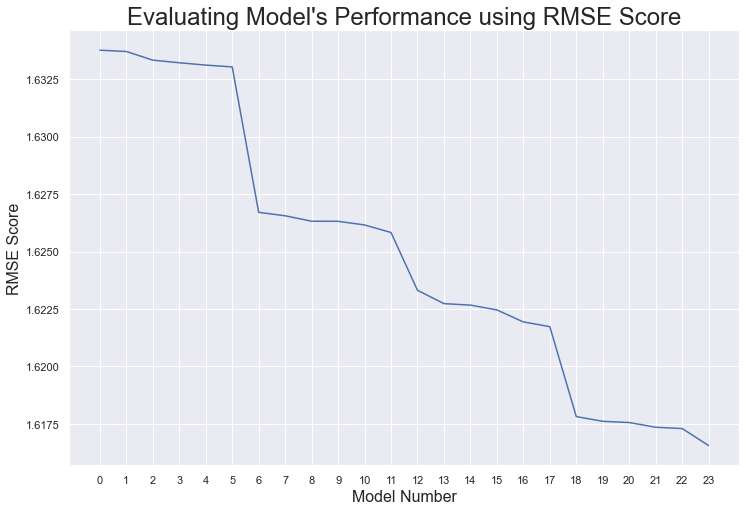

In [83]:
sns.lineplot(range(24),performance.RMSE)
plt.xlabel("Model Number",size = 16)
plt.xticks(range(0,24))
plt.ylabel("RMSE Score",size= 16)
plt.title("Evaluating Model's Performance using RMSE Score",size=24)
plt.show()

In [46]:
#Using ALS model to get recommendations
recommendations = getRecommendations(result,2479,sparse_household_product)
recommendations

,product_id,recommendation_score,manufacturer_id,department,brand,product_category,product_type,package_size
0,9677366.0,1.791176,764,GROCERY,National,PAPER TOWELS,PAPER TOWELS & HOLDERS,352 SQ FT
1,1043494.0,1.768208,1039,GROCERY,National,FROZEN PIZZA,SNACKS/APPETIZERS,NaN
2,1128016.0,1.748075,988,GROCERY,National,MEAT - SHELF STABLE,CHILI: CANNED,15 OZ
3,1103741.0,1.735159,827,GROCERY,National,FRUIT - SHELF STABLE,MANDARIN ORANGES/CITRUS SECT,15 OZ
4,951821.0,1.724735,2186,MEAT-PCKGD,National,LUNCHMEAT,MISCELLANEOUS,8 OZ
5,9878513.0,1.704901,69,GROCERY,Private,FACIAL TISS/DNR NAPKIN,FACIAL TISSUE & PAPER HANDKE,85 CT
6,862070.0,1.697986,531,GROCERY,National,CANNED JUICES,OTHER CITRUS JUICES (OVER 50%,64 OZ
7,1101174.0,1.690250,1251,GROCERY,National,SOUP,CONDENSED SOUP,10.75 OZ
8,1110764.0,1.666240,988,GROCERY,National,MEAT - SHELF STABLE,CHILI: CANNED,10.5 OZ
9,954673.0,1.647356,1075,GROCERY,National,CRACKERS/MISC BKD FD,SNACK CRACKERS,10 OZ


In [47]:
#Recommendation by number of times a product was purchased in different transactions
result = generateRequiredDataframe(transactions)
sparse_product_household,sparse_household_product = createSparseMatrix(result)
trainModel(sparse_product_household)
recommendations = getRecommendations(result,1,sparse_household_product)
recommendations

  0%|          | 0/100 [00:00<?, ?it/s]

,product_id,recommendation_score,manufacturer_id,department,brand,product_category,product_type,package_size
0,948953.0,1.634143,917,DRUG GM,National,BATTERIES,ALKALINE BATTERIES,NaN
1,8090532.0,1.420336,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ
2,1043128.0,1.264381,827,GROCERY,National,FRUIT - SHELF STABLE,PINEAPPLE,20 OZ
3,1051211.0,1.258394,1266,GROCERY,National,PNT BTR/JELLY/JAMS,PEANUT BUTTER,18 OZ
4,1091365.0,1.246848,2,SALAD BAR,National,SALAD BAR,SALAD BAR FRESH FRUIT,NaN
5,5572828.0,1.234684,2224,GROCERY,National,SOFT DRINKS,SFT DRNK SNGL SRV BTL CARB (EX,20 OZ
6,17104444.0,1.228172,693,DRUG GM,National,CANDY - PACKAGED,SEASONAL CANDY BAGS-CHOCOLATE,12 OZ
7,948670.0,1.221002,2,DRUG GM,National,TICKETS,TICKETS,NaN
8,921504.0,1.177196,4209,DELI,National,DELI MEATS,MEAT:HAM BULK,NaN
9,1110843.0,1.117946,2,SALAD BAR,National,SALAD BAR,SALAD BAR FRESH FRUIT,NaN


In [48]:
#Find 10 similar products for softdrink with id:8090532.0
similar_products = getSimilarProducts(result,8090532.0,10)
similar_products

,product_id,similarity_score,manufacturer_id,department,brand,product_category,product_type,package_size
0,8090532.0,1.000000,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ
1,12605292.0,0.751545,2551,DRUG GM,National,CHRISTMAS SEASONAL,CHRISTMAS LIGHTS,20 CT
2,5589752.0,0.751545,69,GROCERY,Private,WATER - CARBONATED/FLVRD DRINK,DISTILLED WATER,GAL
3,12606012.0,0.751545,2551,DRUG GM,National,CHRISTMAS SEASONAL,CHRISTMAS LIGHTS,NaN
4,12604493.0,0.751545,484,DRUG GM,National,CHRISTMAS SEASONAL,DECOR,NaN
5,9190629.0,0.751545,2551,DRUG GM,National,ELECTRICAL SUPPPLIES,EXTENSION CORDS,NaN
6,12605734.0,0.751545,2551,DRUG GM,National,CHRISTMAS SEASONAL,CHRISTMAS LIGHTS,NaN
7,5568419.0,0.751545,1208,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ
8,8090513.0,0.664317,2224,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ
9,8090536.0,0.654973,103,GROCERY,National,SOFT DRINKS,SOFT DRINKS 12/18&15PK CAN CAR,12 OZ
